In [2]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git


Cloning into 'uni2ts'...
remote: Enumerating objects: 716, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 716 (delta 159), reused 152 (delta 128), pack-reused 446
Receiving objects: 100% (716/716), 5.22 MiB | 1.30 MiB/s, done.
Resolving deltas: 100% (328/328), done.


## Import the packeges

In [1]:
import os
import sys
import matplotlib.pyplot as plt
root_path = os.path.abspath(os.path.join(os.getcwd(), './uni2ts/src'))
sys.path.append(root_path)
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch.model.predictor import PyTorchPredictor
import yfinance as yf

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import backtrader as bt

/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch Data from Yahoo Finance

In [2]:

# Step 1: Fetch Data from Yahoo Finance
def fetch_data(symbol, since):
    try:
        ticker = yf.Ticker(symbol)
        ohlcv = ticker.history(period='1d', start=since)
        ohlcv.reset_index(inplace=True)
        ohlcv['timestamp'] = pd.to_datetime(ohlcv['Date'])
        ohlcv.set_index('timestamp', inplace=True)
        ohlcv = ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]
        ohlcv.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
        
        # Ensure the data is uniformly spaced by resampling
        ohlcv = ohlcv.resample('D').ffill()
        
        return ohlcv
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

## Load and predict 

In [3]:
def load_and_predict(data):
    # Use only the 'close' price for forecasting
    df = data[['close']].rename(columns={'close': 'target'})

    # Ensure data is sorted
    df = df.sort_index()

    # Step 2: Prepare the Data for the Model
    # Convert into GluonTS dataset
    ds = PandasDataset(dict(df), freq="D")

    # Split into train/test set
    TEST = 100  # Define the length of the test set
    PDT = 20  # Define the prediction length
    train, test_template = split(ds, offset=-TEST)

    # Ensure the length of the dataset is sufficient for rolling window evaluation
    total_length = len(df)
    if total_length < TEST + PDT:
        raise ValueError(f"Not enough data points. Total length: {total_length}, TEST: {TEST}, PDT: {PDT}")

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,
        windows=TEST // PDT,
        distance=PDT
    )

    # Step 3: Load the Model and Make Predictions
    SIZE = "small"  # Model size
    CTX = 200  # Context length
    PSZ = "auto"  # Patch size
    BSZ = 32  # Batch size

    # Prepare pre-trained model by downloading model weights from Hugging Face hub
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    # Step 4: Plot the Results
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    try:
        inp = next(input_it)
        label = next(label_it)
        forecast = next(forecast_it)

        plot_single(
            inp, 
            label, 
            forecast, 
            context_length=CTX,
            name="pred",
            show_label=True,
        )
        plt.show()
    except StopIteration:
        print("Error: Not enough data points to generate forecasts.")
    
    return forecasts

## Define the strategies

In [4]:
# Define the strategies
class RsiBollingerBandsStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('bb_period', 20),
        ('bb_dev', 2),
        ('oversold', 30),
        ('overbought', 70),
    )

    def __init__(self, predictions):
        self.rsi = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_period)
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_dev)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.rsi < self.params.oversold and self.data.close <= self.bbands.lines.bot:
                self.buy()
        else:
            if self.rsi > self.params.overbought or self.data.close >= self.bbands.lines.top:
                self.sell()
        
        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class MacdStrategy(bt.Strategy):
    params = (
        ('macd1_period', 12),
        ('macd2_period', 26),
        ('signal_period', 9),
    )

    def __init__(self, predictions):
        self.macd = bt.indicators.MACDHisto(period_me1=self.params.macd1_period, period_me2=self.params.macd2_period, period_signal=self.params.signal_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.macd.lines.histo[0] > 0 and self.macd.lines.histo[-1] <= 0:
                self.buy()
        else:
            if self.macd.lines.histo[0] < 0 and self.macd.lines.histo[-1] >= 0:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class StochasticOscillatorStrategy(bt.Strategy):
    params = (
        ('stoch_period', 14),
        ('stoch_low', 20),
        ('stoch_high', 80),
    )

    def __init__(self, predictions):
        self.stoch = bt.indicators.Stochastic(period=self.params.stoch_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.stoch.lines.percK[0] < self.params.stoch_low and self.stoch.lines.percK[-1] >= self.params.stoch_low:
                self.buy()
        else:
            if self.stoch.lines.percK[0] > self.params.stoch_high and self.stoch.lines.percK[-1] <= self.params.stoch_high:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

## Run the backtest strategies


Running backtest for RsiBollingerBandsStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


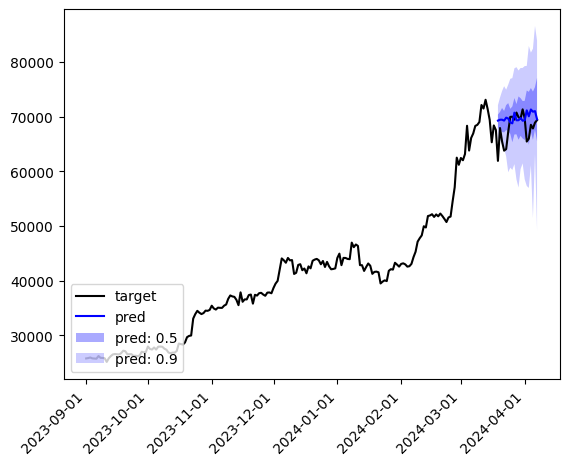

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 101338.30


<IPython.core.display.Javascript object>

Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 101338.29630859377
Sharpe Ratio: -1.6588513094978394
Max Drawdown: 2.538388732547052
Total Trades: 2
Winning Trades: 1
Losing Trades: 0
Total Return: 0.013294202280243533

Running backtest for MacdStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 117093.09
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 117093.08969531255
Sharpe Ratio: 2.3151351845615338
Max Drawdown: 9.211955039933201
Total Trades: 11
Winning Trades: 5
Losing Trades: 6
Total Return: 0.15779907087868106

Running backtest for StochasticOscillatorStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100279.05
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100279.050984375
Sharpe Ratio: -1.409165927071452
Max Drawdown: 8.15567929488038
Total Trades: 5
Winning Trades: 3
Losing Trades: 1
Total Return: 0.002786623599212957


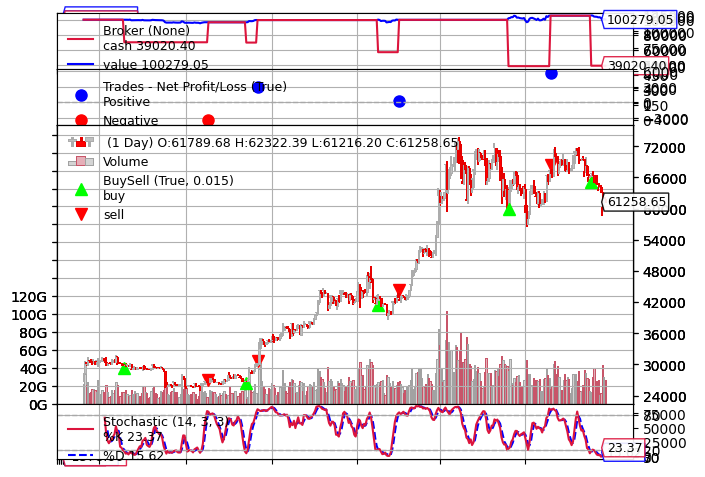

In [5]:

def run_backtest(strategy_class, symbol, since):
    # Fetch data for backtesting
    data = fetch_data(symbol, since)

    # Load and make predictions
    predictions = load_and_predict(data)

    # Initialize cerebro
    cerebro = bt.Cerebro()
    
    # Add data feed
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy with predictions
    cerebro.addstrategy(strategy_class, predictions=predictions)
    
    # Set broker settings
    cerebro.broker.set_cash(100000)
    cerebro.broker.setcommission(commission=0.002)

    # Add analyzers for performance metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

    # Print starting conditions
    start_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {start_value:.2f}')

    # Run backtest
    results = cerebro.run()

    # Print ending conditions
    end_value = cerebro.broker.getvalue()
    print(f'Ending Portfolio Value: {end_value:.2f}')

    # Extracting backtest metrics
    strat = results[0]

    # Prepare results
    result_dict = {
        "Starting Portfolio Value": start_value,
        "Ending Portfolio Value": end_value,
        "Sharpe Ratio": strat.analyzers.sharpe.get_analysis().get('sharperatio', 'N/A'),
        "Max Drawdown": strat.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 'N/A'),
        "Total Trades": strat.analyzers.trades.get_analysis().get('total', {}).get('total', 'N/A'),
        "Winning Trades": strat.analyzers.trades.get_analysis().get('won', {}).get('total', 'N/A'),
        "Losing Trades": strat.analyzers.trades.get_analysis().get('lost', {}).get('total', 'N/A'),
        "Total Return": strat.analyzers.returns.get_analysis().get('rtot', 'N/A')
    }

    # Plot the results
    cerebro.plot(style='candlestick')

    # Print metrics
    print("Metrics:")
    for key, value in result_dict.items():
        print(f"{key}: {value}")

    return result_dict

if __name__ == "__main__":
    symbol = 'BTC-USD'
    since = '2023-06-20'
    
    strategies = [RsiBollingerBandsStrategy, MacdStrategy, StochasticOscillatorStrategy]
    
    for strategy in strategies:
        print(f"\nRunning backtest for {strategy.__name__}")
        run_backtest(strategy, symbol, since)


## Complete code with since as starting date and end date is current date

/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running backtest for RsiBollingerBandsStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


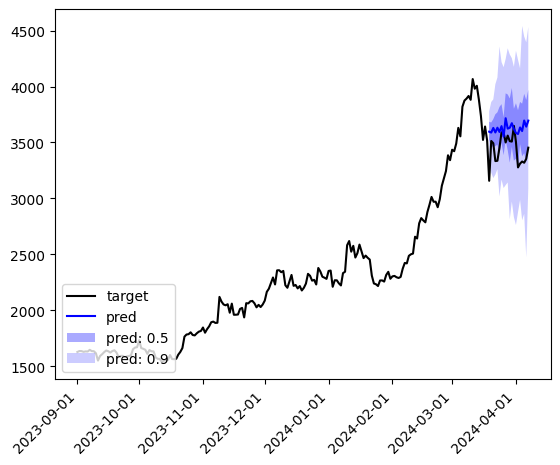

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100044.12


<IPython.core.display.Javascript object>

Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100044.11551171874
Sharpe Ratio: -44.33552762009954
Max Drawdown: 0.178009113397425
Total Trades: 1
Winning Trades: 1
Losing Trades: 0
Total Return: 0.00044105783687816173
Running backtest for MacdStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100927.54
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100927.54213549806
Sharpe Ratio: -1.2165196237868399
Max Drawdown: 1.3007929155129758
Total Trades: 13
Winning Trades: 4
Losing Trades: 9
Total Return: 0.009232668796317978
Running backtest for StochasticOscillatorStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100740.58
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100740.57570678712
Sharpe Ratio: -1.184578981873076
Max Drawdown: 0.34094949414063014
Total Trades: 5
Winning Trades: 3
Losing Trades: 1
Total Return: 0.0073784690915939906


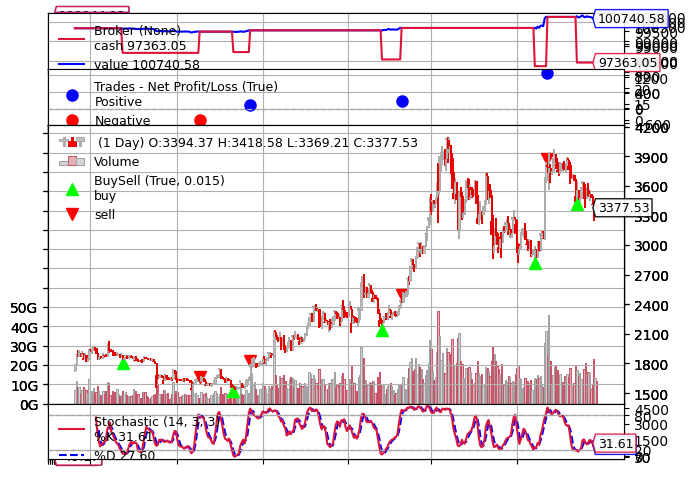

In [1]:
import os
import sys 
import matplotlib.pyplot as plt
root_path = os.path.abspath(os.path.join(os.getcwd(), './uni2ts/src'))
sys.path.append(root_path)
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch.model.predictor import PyTorchPredictor
import yfinance as yf

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import backtrader as bt

# Step 1: Fetch Data from Yahoo Finance
def fetch_data(symbol, since):
    try:
        ticker = yf.Ticker(symbol)
        ohlcv = ticker.history(period='1d', start=since)
        ohlcv.reset_index(inplace=True)
        ohlcv['timestamp'] = pd.to_datetime(ohlcv['Date'])
        ohlcv.set_index('timestamp', inplace=True)
        ohlcv = ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]
        ohlcv.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
        
        # Ensure the data is uniformly spaced by resampling
        ohlcv = ohlcv.resample('D').ffill()
        
        return ohlcv
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

def load_and_predict(data):
    # Use only the 'close' price for forecasting
    df = data[['close']].rename(columns={'close': 'target'})

    # Ensure data is sorted
    df = df.sort_index()

    # Step 2: Prepare the Data for the Model
    # Convert into GluonTS dataset
    ds = PandasDataset(dict(df), freq="D")

    # Split into train/test set
    TEST = 100  # Define the length of the test set
    PDT = 20  # Define the prediction length
    train, test_template = split(ds, offset=-TEST)

    # Ensure the length of the dataset is sufficient for rolling window evaluation
    total_length = len(df)
    if total_length < TEST + PDT:
        raise ValueError(f"Not enough data points. Total length: {total_length}, TEST: {TEST}, PDT: {PDT}")

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,
        windows=TEST // PDT,
        distance=PDT
    )

    # Step 3: Load the Model and Make Predictions
    SIZE = "small"  # Model size
    CTX = 200  # Context length
    PSZ = "auto"  # Patch size
    BSZ = 32  # Batch size

    # Prepare pre-trained model by downloading model weights from Hugging Face hub
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    # Step 4: Plot the Results
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    try:
        inp = next(input_it)
        label = next(label_it)
        forecast = next(forecast_it)

        plot_single(
            inp, 
            label, 
            forecast, 
            context_length=CTX,
            name="pred",
            show_label=True,
        )
        plt.show()
    except StopIteration:
        print("Error: Not enough data points to generate forecasts.")
    
    return forecasts

# Define the strategies
class RsiBollingerBandsStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('bb_period', 20),
        ('bb_dev', 2),
        ('oversold', 30),
        ('overbought', 70),
    )

    def __init__(self, predictions):
        self.rsi = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_period)
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_dev)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.rsi < self.params.oversold and self.data.close <= self.bbands.lines.bot:
                self.buy()
        else:
            if self.rsi > self.params.overbought or self.data.close >= self.bbands.lines.top:
                self.sell()
        
        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class MacdStrategy(bt.Strategy):
    params = (
        ('macd1_period', 12),
        ('macd2_period', 26),
        ('signal_period', 9),
    )

    def __init__(self, predictions):
        self.macd = bt.indicators.MACDHisto(period_me1=self.params.macd1_period, period_me2=self.params.macd2_period, period_signal=self.params.signal_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.macd.lines.histo[0] > 0 and self.macd.lines.histo[-1] <= 0:
                self.buy()
        else:
            if self.macd.lines.histo[0] < 0 and self.macd.lines.histo[-1] >= 0:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class StochasticOscillatorStrategy(bt.Strategy):
    params = (
        ('stoch_period', 14),
        ('stoch_low', 20),
        ('stoch_high', 80),
    )

    def __init__(self, predictions):
        self.stoch = bt.indicators.Stochastic(period=self.params.stoch_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.stoch.lines.percK[0] < self.params.stoch_low and self.stoch.lines.percK[-1] >= self.params.stoch_low:
                self.buy()
        else:
            if self.stoch.lines.percK[0] > self.params.stoch_high and self.stoch.lines.percK[-1] <= self.params.stoch_high:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

def run_backtest(strategy_class, symbol, since):
    # Fetch data for backtesting
    data = fetch_data(symbol, since)

    # Load and make predictions
    predictions = load_and_predict(data)

    # Initialize cerebro
    cerebro = bt.Cerebro()
    
    # Add data feed
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy with predictions
    cerebro.addstrategy(strategy_class, predictions=predictions)
    
    # Set broker settings
    cerebro.broker.set_cash(100000)
    cerebro.broker.setcommission(commission=0.002)

    # Add analyzers for performance metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

    # Print starting conditions
    start_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {start_value:.2f}')

    # Run backtest
    results = cerebro.run()

    # Print ending conditions
    end_value = cerebro.broker.getvalue()
    print(f'Ending Portfolio Value: {end_value:.2f}')

    # Extracting backtest metrics
    strat = results[0]

    # Prepare results
    result_dict = {
        "Starting Portfolio Value": start_value,
        "Ending Portfolio Value": end_value,
        "Sharpe Ratio": strat.analyzers.sharpe.get_analysis().get('sharperatio', 'N/A'),
        "Max Drawdown": strat.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 'N/A'),
        "Total Trades": strat.analyzers.trades.get_analysis().get('total', {}).get('total', 'N/A'),
        "Winning Trades": strat.analyzers.trades.get_analysis().get('won', {}).get('total', 'N/A'),
        "Losing Trades": strat.analyzers.trades.get_analysis().get('lost', {}).get('total', 'N/A'),
        "Total Return": strat.analyzers.returns.get_analysis().get('rtot', 'N/A')
    }

    # Plot the results
    cerebro.plot(style='candlestick')

    # Print metrics
    print("Metrics:")
    for key, value in result_dict.items():
        print(f"{key}: {value}")

    return result_dict

if __name__ == "__main__":
    symbol = 'ETH-USD'
    since = '2023-06-20'
    
    strategies = [RsiBollingerBandsStrategy, MacdStrategy, StochasticOscillatorStrategy]
    
    for strategy in strategies:
        print(f"Running backtest for {strategy.__name__}")
        run_backtest(strategy, symbol, since)


## Complete code with start date and end date is specified

/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running backtest for RsiBollingerBandsStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


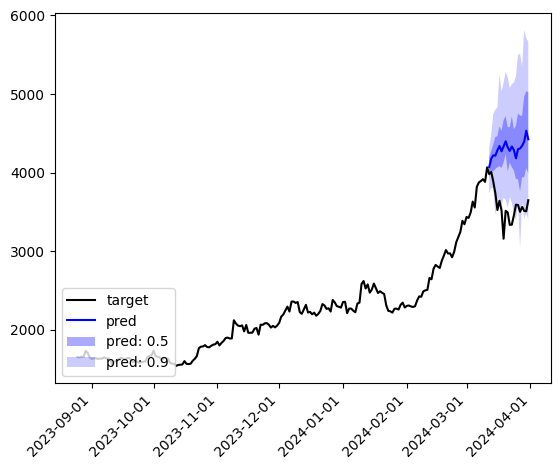

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100044.12


<IPython.core.display.Javascript object>

Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100044.11551171874
Sharpe Ratio: -44.33552762009954
Max Drawdown: 0.178009113397425
Total Trades: 1
Winning Trades: 1
Losing Trades: 0
Total Return: 0.00044105783687816173
Running backtest for MacdStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100927.54
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100927.54213549806
Sharpe Ratio: -1.2165196237868399
Max Drawdown: 1.3007929155129758
Total Trades: 13
Winning Trades: 4
Losing Trades: 9
Total Return: 0.009232668796317978
Running backtest for StochasticOscillatorStrategy


/Users/Air/crypto-trading-backtesting/.crypto/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100922.40
Metrics:
Starting Portfolio Value: 100000
Ending Portfolio Value: 100922.39797241212
Sharpe Ratio: -0.8647908600419059
Max Drawdown: 0.34094949414063014
Total Trades: 5
Winning Trades: 3
Losing Trades: 1
Total Return: 0.009181698624275226


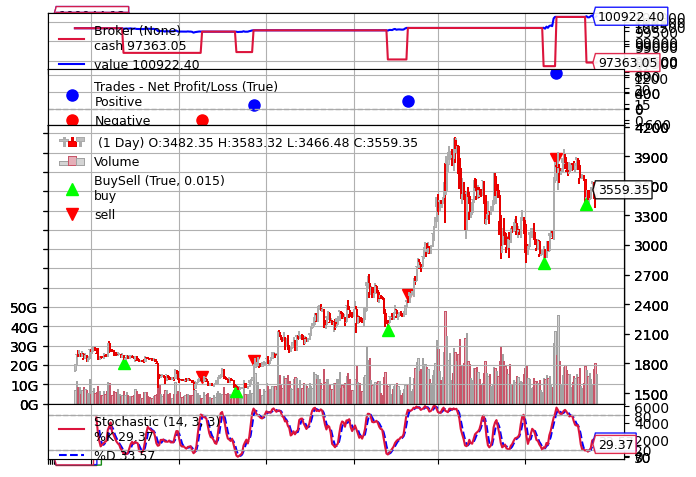

In [1]:
import os
import sys 
root_path = os.path.abspath(os.path.join(os.getcwd(), './uni2ts/src'))
sys.path.append(root_path)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch.model.predictor import PyTorchPredictor
import yfinance as yf

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import backtrader as bt

# Step 1: Fetch Data from Yahoo Finance
def fetch_data(symbol, start_date, end_date):
    try:
        ticker = yf.Ticker(symbol)
        ohlcv = ticker.history(start=start_date, end=end_date)
        ohlcv.reset_index(inplace=True)
        ohlcv['timestamp'] = pd.to_datetime(ohlcv['Date'])
        ohlcv.set_index('timestamp', inplace=True)
        ohlcv = ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]
        ohlcv.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
        
        # Ensure the data is uniformly spaced by resampling
        ohlcv = ohlcv.resample('D').ffill()
        
        return ohlcv
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

def load_and_predict(data):
    # Use only the 'close' price for forecasting
    df = data[['close']].rename(columns={'close': 'target'})

    # Ensure data is sorted
    df = df.sort_index()

    # Step 2: Prepare the Data for the Model
    # Convert into GluonTS dataset
    ds = PandasDataset(dict(df), freq="D")

    # Split into train/test set
    TEST = 100  # Define the length of the test set
    PDT = 20  # Define the prediction length
    train, test_template = split(ds, offset=-TEST)

    # Ensure the length of the dataset is sufficient for rolling window evaluation
    total_length = len(df)
    if total_length < TEST + PDT:
        raise ValueError(f"Not enough data points. Total length: {total_length}, TEST: {TEST}, PDT: {PDT}")

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,
        windows=TEST // PDT,
        distance=PDT
    )

    # Step 3: Load the Model and Make Predictions
    SIZE = "small"  # Model size
    CTX = 200  # Context length
    PSZ = "auto"  # Patch size
    BSZ = 32  # Batch size

    # Prepare pre-trained model by downloading model weights from Hugging Face hub
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    # Step 4: Plot the Results
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    try:
        inp = next(input_it)
        label = next(label_it)
        forecast = next(forecast_it)

        plot_single(
            inp, 
            label, 
            forecast, 
            context_length=CTX,
            name="pred",
            show_label=True,
        )
        plt.show()
    except StopIteration:
        print("Error: Not enough data points to generate forecasts.")
    
    return forecasts

# Define the strategies
class RsiBollingerBandsStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('bb_period', 20),
        ('bb_dev', 2),
        ('oversold', 30),
        ('overbought', 70),
    )

    def __init__(self, predictions):
        self.rsi = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_period)
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_dev)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.rsi < self.params.oversold and self.data.close <= self.bbands.lines.bot:
                self.buy()
        else:
            if self.rsi > self.params.overbought or self.data.close >= self.bbands.lines.top:
                self.sell()
        
        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class MacdStrategy(bt.Strategy):
    params = (
        ('macd1_period', 12),
        ('macd2_period', 26),
        ('signal_period', 9),
    )

    def __init__(self, predictions):
        self.macd = bt.indicators.MACDHisto(period_me1=self.params.macd1_period, period_me2=self.params.macd2_period, period_signal=self.params.signal_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.macd.lines.histo[0] > 0 and self.macd.lines.histo[-1] <= 0:
                self.buy()
        else:
            if self.macd.lines.histo[0] < 0 and self.macd.lines.histo[-1] >= 0:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

class StochasticOscillatorStrategy(bt.Strategy):
    params = (
        ('stoch_period', 14),
        ('stoch_low', 20),
        ('stoch_high', 80),
    )

    def __init__(self, predictions):
        self.stoch = bt.indicators.Stochastic(period=self.params.stoch_period)
        self.predictions = predictions
        self.current_prediction = next(iter(self.predictions))

    def next(self):
        if not self.position:
            if self.stoch.lines.percK[0] < self.params.stoch_low and self.stoch.lines.percK[-1] >= self.params.stoch_low:
                self.buy()
        else:
            if self.stoch.lines.percK[0] > self.params.stoch_high and self.stoch.lines.percK[-1] <= self.params.stoch_high:
                self.sell()

        # Move to the next prediction if available
        try:
            self.current_prediction = next(iter(self.predictions))
        except StopIteration:
            pass

def run_backtest(strategy_class, symbol, start_date, end_date):
    # Fetch data for backtesting
    data = fetch_data(symbol, start_date, end_date)

    # Load and make predictions
    predictions = load_and_predict(data)

    # Initialize cerebro
    cerebro = bt.Cerebro()
    
    # Add data feed
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy with predictions
    cerebro.addstrategy(strategy_class, predictions=predictions)
    
    # Set broker settings
    cerebro.broker.set_cash(100000)
    cerebro.broker.setcommission(commission=0.002)

    # Add analyzers for performance metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

    # Print starting conditions
    start_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {start_value:.2f}')

    # Run backtest
    results = cerebro.run()

    # Print ending conditions
    end_value = cerebro.broker.getvalue()
    print(f'Ending Portfolio Value: {end_value:.2f}')

    # Extracting backtest metrics
    strat = results[0]

    # Prepare results
    result_dict = {
        "Starting Portfolio Value": start_value,
        "Ending Portfolio Value": end_value,
        "Sharpe Ratio": strat.analyzers.sharpe.get_analysis().get('sharperatio', 'N/A'),
        "Max Drawdown": strat.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 'N/A'),
        "Total Trades": strat.analyzers.trades.get_analysis().get('total', {}).get('total', 'N/A'),
        "Winning Trades": strat.analyzers.trades.get_analysis().get('won', {}).get('total', 'N/A'),
        "Losing Trades": strat.analyzers.trades.get_analysis().get('lost', {}).get('total', 'N/A'),
        "Total Return": strat.analyzers.returns.get_analysis().get('rtot', 'N/A')
    }

    # Plot the results
    cerebro.plot(style='candlestick')

    # Print metrics
    print("Metrics:")
    for key, value in result_dict.items():
        print(f"{key}: {value}")

    return result_dict

if __name__ == "__main__":
    symbol = 'ETH-USD'
    start_date = '2023-06-20'
    end_date = '2024-06-20'
    
    strategies = [RsiBollingerBandsStrategy, MacdStrategy, StochasticOscillatorStrategy]
    
    for strategy in strategies:
        print(f"Running backtest for {strategy.__name__}")
        run_backtest(strategy, symbol, start_date, end_date)
